# Modeling Transformer

## import tf ...

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

## Positional Encoding
한번에 모든 토큰을 입력으로 주기 때문에, 위치마다 다른 Encoding이 들어가야 합니다. Positional Encoding은 SInusoidal Encoding을 주로 사용합니다.
### Sinusoidal Encoding

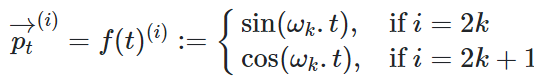
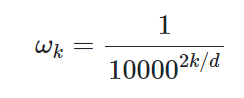
$$\\
T = \frac {2 \pi}{\omega} 에서,\; T_k = 2 \pi \times 10000^{2k/d} 이므로,\\ k가\; 커질수록(embedding에서의\; 차원이\; 깊어질수록)\; 주기는\; 길어지고\; k=d/2까지\; 커지므로,\\\; 가장\; 깊은\; 차원에서는\; 주기가\; 2 \pi \times 10000\; 이\; 됩니다.
\\
$$
트랜스포머에서 내적이 아주 빈번하게 사용된다는 점을 감안할 때, orthonormality(정의된 내적에서, 자기 자신과 내적하면 1, 나머지와 내적하면 0이 되는 성질)은 모든 positional encoding vector가 depthwise independent하게 만듭니다
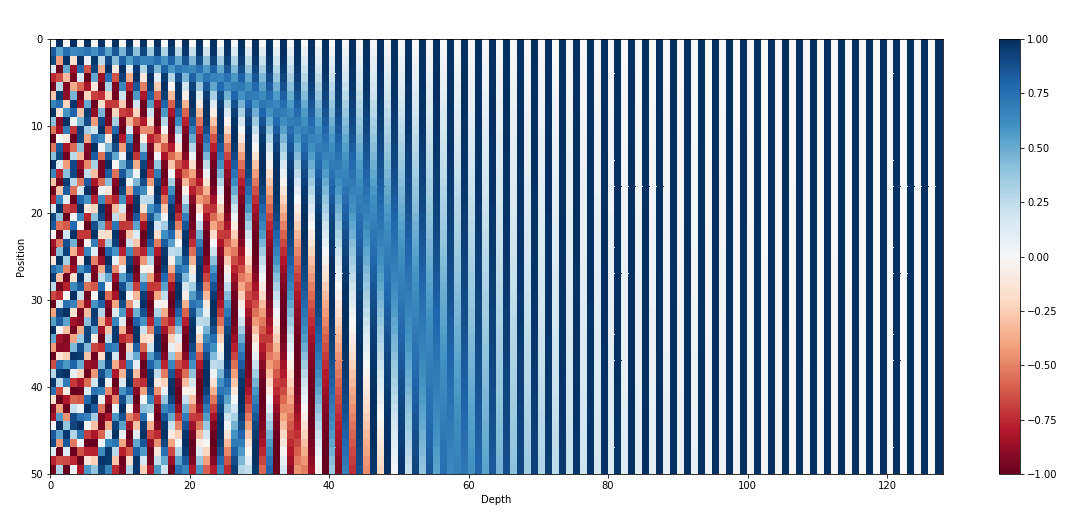
각 가로줄이 하나의 positional encoding vector에 대응됩니다.

positional vector는 depthwise independent하고, translation이 잘 정의되어 있어 x번째 position에서 x+$\Delta$x 로의 변환을 block diagonal 행렬
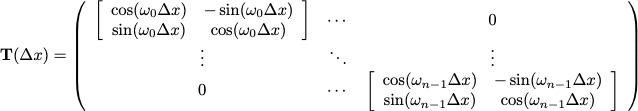
로 정의할 수 있습니다. 이 때, 두 벡터 사이의 내적을 구한다면 $(x+\Delta x)^t x\;=\;(T(\Delta x)x)^tx\;=\;x^tT(\Delta x)^tx$입니다. 결국 회전변환을 적용한 벡터와의 내적이 되므로, 차이 $\Delta x$가 커질수록 내적이 작아지는 경향성을 볼 수 있습니다.

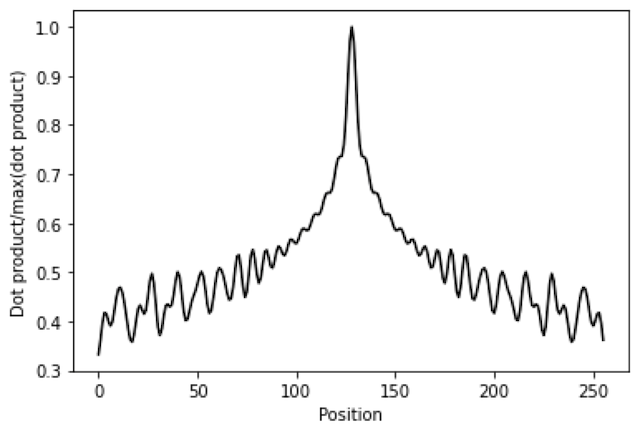
내적을 사용하는 Transformer 구조에서 이는 자연스럽게 모델이 거리를 학습할 수 있도록 도움을 줍니다


[수학 관련 참고글](https://towardsdatascience.com/master-positional-encoding-part-i-63c05d90a0c3)

### Multiple Positional Encoding
이번 프로젝트에서는 형태소로 분리한 정제된 문장을 보조 입력으로 넣어줄 예정입니다. 따라서 원래의 문장과는 영향을 미치지 않으면서 같은 내적이 정의된 벡터들이 필요합니다.
위의 내적에서 거리가 가까울수록 PE 벡터 간 내적이 크다는 것을 생각하면, 원래의 임베딩 벡터와 보조 임베딩 벡터에 더해진 PE벡터간 내적은 일정해야 바람직합니다. 따라서, 
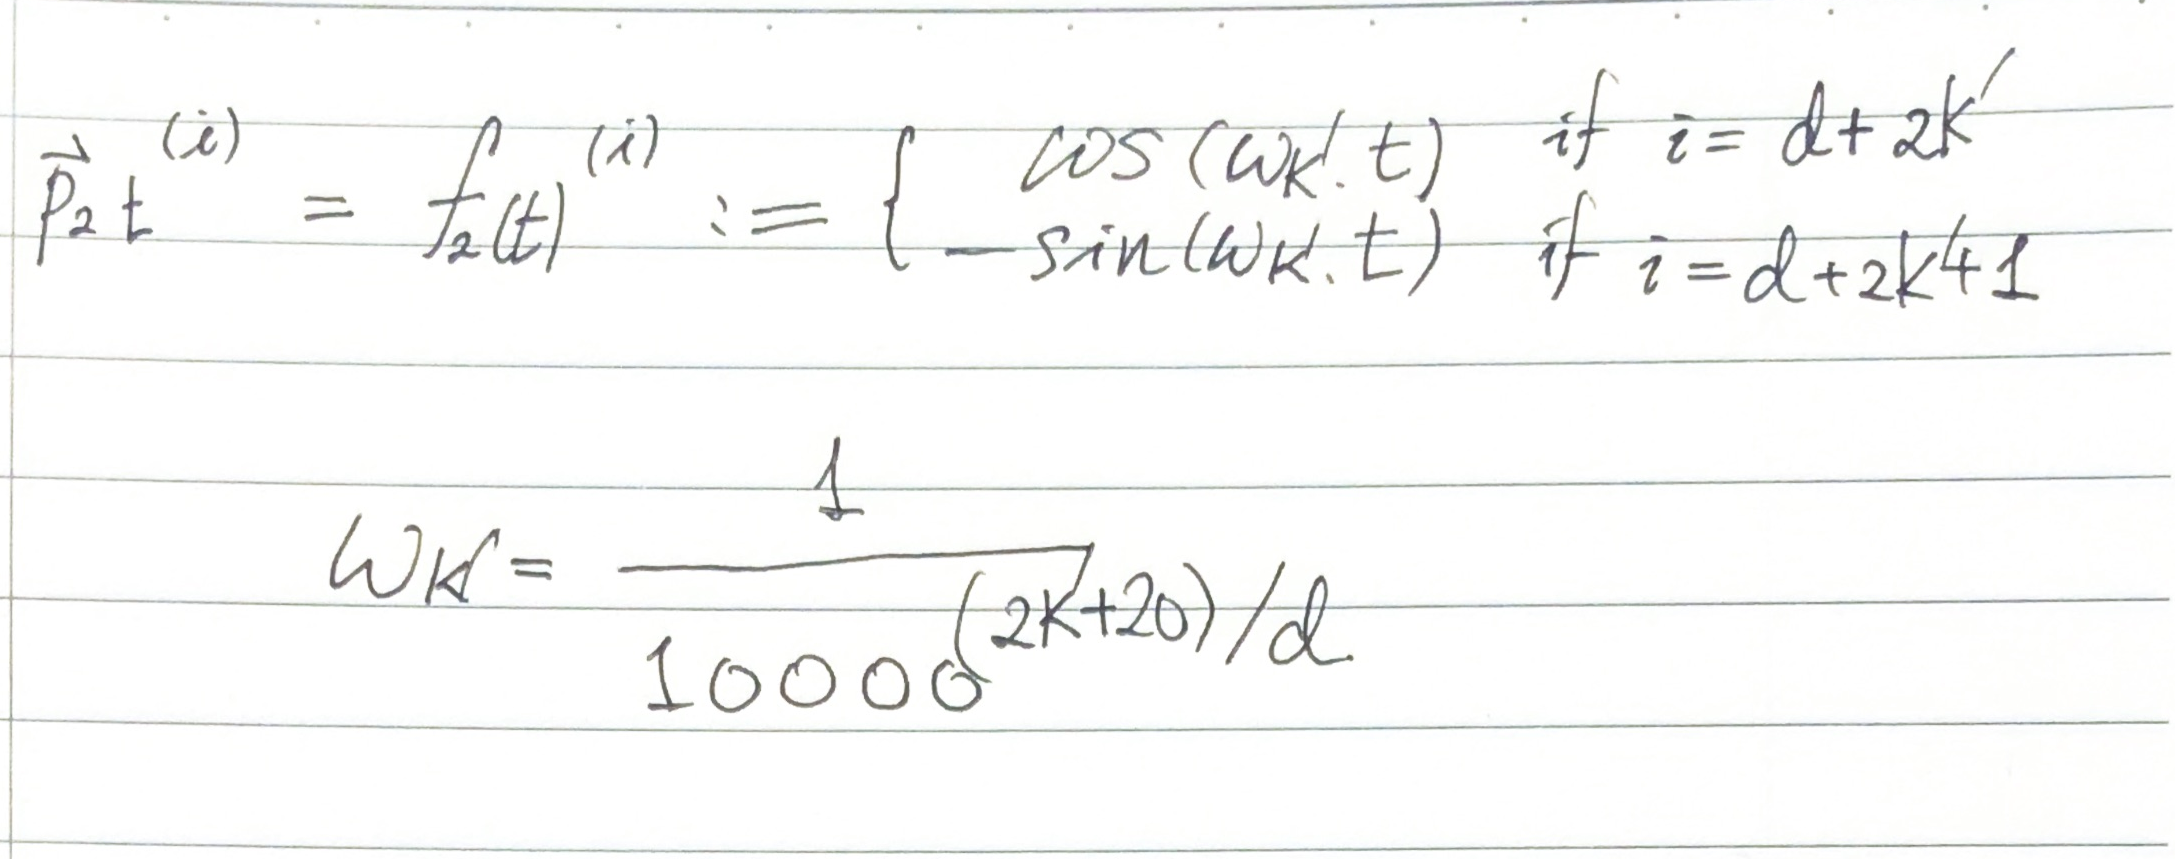
을 추가해봅니다

## Implement PE Layer

In [2]:
# 포지셔널 인코딩 레이어1 - 36부터 시작합니다.
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2) + 36) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [3]:
# 포지셔널 인코딩 레이어2, 36부터 시작합니다.
class PositionalEncoding2(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding2, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, ((2 * (i // 2)) + 36) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 -sine 함수 적용
        neg_sines = -tf.math.sin(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([cosines, neg_sines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

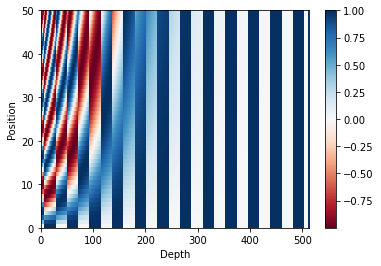

In [4]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

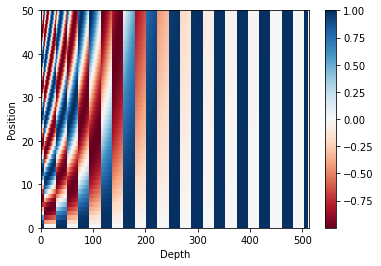

In [5]:
sample_pos_encoding_2 = PositionalEncoding2(50, 512)

plt.pcolormesh(sample_pos_encoding_2.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Scaled dot product attention

In [6]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

## Multi-head attention

In [7]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

## Look-ahead masking

In [8]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [9]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


값이 0인 부분만 1을 출력하는 masking을 만들었습니다.

In [10]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [11]:
tf.linalg.band_part(tf.ones((4, 4)), -1, 0)

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]], dtype=float32)>

In [12]:
1 - tf.linalg.band_part(tf.ones((4, 4)), -1, 0)

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 1., 1., 1.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.]], dtype=float32)>

In [13]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


# Implement Vanilla Transformer 

In [14]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [15]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [16]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [17]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
    inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
    outputs=outputs,
    name=name)

# Load data

In [18]:
os.getenv('HOME')

'/aiffel'

In [19]:
dir_path = '/aiffel/aiffel/transformer_chatbot/data'
path_to_dataset = os.path.join(dir_path, 'ChatbotData .csv')
print(dir_path)

/aiffel/aiffel/transformer_chatbot/data


In [20]:
import pandas as pd

In [21]:
data = pd.read_csv(path_to_dataset)

In [43]:
data.iloc[500:550,:]

,Q,A,label
500,나 보이스피싱 당한 거 같은데 어떡해?,경찰에 신고하고 취할 수 있는 조취를 취해보세요.,0
501,나 비만이야,건강하게 운동해보세요.,0
502,나 사랑하니?,많이 사랑해요!,0
503,나 상 받는대!,축하합니다!,0
504,나 새 옷 샀다,꼬까옷 개시해보세요.,0
505,나 서류에서 광탈했어,자책하지 마세요.,0
506,나 소개팅한다!,성공을 기원합니다.,0
507,나 속은 거 같아,다음부터 속지 마세요.,0
508,나 속은듯,기분나쁘겠어요.,0
509,나 수학여행 간다,친구들과 좋은 추억 만들고 오세요.,0


In [22]:
data[data['Q'].str.contains('ㅋ')]

,Q,A,label
1153,단둘이는 처음 만나는 날ㅋㅋ,서로를 아는 좋은 기회가 되겠네요.,0
2936,안경 벗었는데 차이가 없어ㅋㅋ,이게 정상이죠.,0
6967,어제 연락햇는데ㅋㅋ,말씀해보세요.,1
6979,어제 헤어진 여자친구 연락 왔다고 글 썼는데 ㅋㅋ,좋은 연락이었길 바랍니다.,1
8272,착각이였나보네ㅋㅋ,상대의 의중을 알긴 쉽지 않죠.,1
8538,헤어지고 한달 이제야 느낌온다 ㅋ,후폭풍이 이제 왔나봐요.,1
8616,헤어진지 1년 뭐하는건지ㅋ,새로운 사람으로 잊혀질 거예요.,1


In [23]:
data[data['Q'].str.contains('\.\.')]

,Q,A,label
2026,버려야 되는데..,잘 버리는 것도 중요해요.,0


In [24]:
data[data['Q'].str.contains('ㅜ')]

,Q,A,label
2229,비트코인 ㅜㅜ,안타깝지만 잊어버리세요.,0
5240,회식 좀 그만 했으면ㅜㅜ,가기 싫어도 가야겠죠.,0
5723,꿈꾸니까 진짜 힘드네ㅜ,꿈이 웬수네요.,1
5786,나만 구질하게.ㅜㅜ,구질구질해도 괜찮아요.,1
6708,손가락이 원망스럽네ㅜㅜ,실수했나봅니다.,1
6819,아 오늘 힘드네ㅜㅜ,당신이 힘들지 않았으면 좋겠어요.,1
7179,오늘따라 미치네ㅜㅜ,답답한가봅니다.,1
7692,이제 이곳올일 없을거 같네하하ㅜ,좋은 소식이라고 생각할게요.,1
8057,정말 이해할수가 없네ㅜ,사람 마음은 알기 어렵죠.,1
8200,지옥같은 5월이 다가 오네ㅜㅜ,천국과 지옥이네요.,1


In [25]:
data[data['Q'].str.contains('ㅠ')]

,Q,A,label
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0
211,공무원 시험 힘들어ㅠㅠ,철밥통 되기가 어디 쉽겠어요.,0
2104,보일러 틀고 나갔어ㅠㅠ,이번달 난방비가 많이 나오겠네요.,0
5555,괜찮다가.갑자기 ㅠ,더 괜찮아 지려고 하는 과정일 거예요.,1
5630,그녀는 무슨 생각일까?ㅠ,그녀밖에 알 수가 없죠.,1
5738,꿈ㅠㅠ,꿈에 나왔나요.,1
5811,난 또 바보ㅠㅠ,바보를 사랑하는 사람이 있을 거예요.,1
5987,노래 가사가 참ㅠ,딱 들어맞나봅니다.,1
6058,다시 한번 더 붙잡고 싶어 ㅠㅠ,후회하지 않는다면 지금 잡으세요.,1
6063,다시 힘들어지네 ㅠㅠ,힘든 건 익숙해지지가 않아요.,1


이미 전처리가 잘 되어 있는 것을 알 수 있습니다. 형태소로 분리하여 뒤에 붙여주는 연산을 해봅니다

# Preprocess data

In [26]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)


Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease                        
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done                      
Reading package lists... Done
Building dependency tree       
Reading state information... Done
g++ is already the newest version (4:7.4.0-1ubuntu2.3).
The following additional packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source visualvm icedtea-8-plugin libnss-mdns
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following packages will be upgraded:
  openjdk-8-jdk openjdk-8-jdk-headless openjdk-8-jre openjdk-8-jre-headless
4 upgraded, 0 newly installed, 0 to remove and 71 not upgraded.
Need to get 38.2 MB of archives.
After

mecab을 설치하는데 매우 많은 시행착오가 있었습니다. 이 한 셀로 설치가 가능하지만, 이 정보를 알기까지 돌아왔습니다.

In [44]:
import urllib.request
import pandas as pd
from konlpy.tag import Mecab
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os
import re

tokenizer = Mecab()
stopwords = ['의','이','은', '을','들','는','좀','걍','과','도','를','으로','자','에','와','한','하다', '겠', '음', '네', '어', '하', '고']

In [45]:
data_temp = data.copy()

In [46]:
def preprocess_qna(sentence):
    sentence = re.sub(r'["."]{1,}', r"", sentence)
    sentence = re.sub(r'["?"]{2,}', r" ?? ", sentence)
    sentence = re.sub(r'["!"]{2,}', r" !! ", sentence)
    sentence = re.sub(r'["ㅜ"]{2,}', r" ㅜ ", sentence)
    sentence = re.sub(r'["ㅠ"]{2,}', r" ㅠ ", sentence)
    sentence = re.sub(r'["ㅋ"]{2,}', r" ㅋ ", sentence)
    sentence = re.sub(r'["ㅎ"]{2,}', r" ㅎ ", sentence)
    sentence = re.sub(r'["ㄱ"]{2,}', r" ㄱ ", sentence)
    sentence = re.sub(r'["ㄷ"]{2,}', r" ㄷ ", sentence)
    sentence = re.sub(r'["ㅅ"]{2,}', r" ㅅ ", sentence)
    sentence = re.sub(r'["ㅊ"]{2,}', r" ㅊ ", sentence)
    

    
    sentence = re.sub(r"[^ㄱ-ㅎ|ㅏ-ㅣ|가-힣.?!,' ]+", "", sentence) 
    sentence = re.sub(r'[" "]+', " ", sentence) # 3

    return sentence

def load_data(train_data):
    train_data.drop_duplicates(subset=['Q'], inplace=True)
    train_data['Q'] = train_data['Q'].apply(lambda x: preprocess_qna(str(x)))
    train_data['A'] = train_data['A'].apply(lambda x: preprocess_qna(str(x)))
    train_data = train_data.dropna(how = 'any') 
    
    
    
    tokenized_Qs = []
    for sentence in train_data['Q']:
        tokenized_Q = tokenizer.morphs(sentence) # 토큰화
        tokenized_Q = [word for word in tokenized_Q if not word in stopwords] # 불용어 제거
        tokenized_Qs.append(tokenized_Q)

    tokenized_As = []
    for sentence in train_data['A']:
        tokenized_A = tokenizer.morphs(sentence) # 토큰화
        tokenized_A = [word for word in tokenized_A if not word in stopwords] # 불용어 제거
        tokenized_As.append(tokenized_A)
    
#    words = np.concatenate(X_train).tolist() 
#    counter = Counter(words)
#    counter = counter.most_common(num_words-4)
#    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
#   word_to_index = {word:index for index, word in enumerate(vocab)}
        
 #   def wordlist_to_indexlist(wordlist):
 #       return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
 #   X_train = list(map(wordlist_to_indexlist, X_train))
 #   X_test = list(map(wordlist_to_indexlist, X_test))
        
    return tokenized_Qs, tokenized_As

In [47]:
preprocessed = load_data(data_temp)

In [48]:
preprocessed[0][500:550]

[['나', '사랑', '니', '?'],
 ['나', '상', '받', '는대', '!'],
 ['나', '새', '옷', '샀', '다'],
 ['나', '서류', '에서', '광탈', '했'],
 ['나', '소개팅', '한다', '!'],
 ['나', '속', '거', '같', '아'],
 ['나', '속', '듯'],
 ['나', '수학여행', '간다'],
 ['나', '스마트폰', '중독', '인가', '봐'],
 ['나', '승진', '했'],
 ['나', '실수', '건가'],
 ['나', '실수', '했', '나'],
 ['나', '아재', '인가'],
 ['나', '아직', '어른', '아닌', '거', '같', '아'],
 ['나', '아직', '애', '같', '아'],
 ['나', '어때', '?'],
 ['나', '여기', '서', '뭐', '거', '지'],
 ['나', '연기', '너무', '못', '해', '거짓말', '못'],
 ['나', '열심히', '할', '거', '야'],
 ['나', '오늘', '개불', '쌍'],
 ['나', '오늘', '따라', '잘', '생겨', '보이'],
 ['나', '오늘', '상', '받', '았', '지롱'],
 ['나', '완전', '계', '탔', '!'],
 ['나', '왕따', '야'],
 ['나', '왕따', '인', '거', '같', '아'],
 ['나', '왜', '멍청', '해'],
 ['나', '왜', '이러', '지', '?'],
 ['나', '왜', '케', '못', '생겼', '지'],
 ['나', '요즘', '정신', '놓', '살', '있', '거', '같', '아'],
 ['나', '욕', '먹', '거', '같', '아'],
 ['나', '웃겨', '봐'],
 ['나', '은근', '무시', '애', '있'],
 ['나', '이상', '한가'],
 ['나', '이상', '해', '?'],
 ['나', '이제', '졸업', '해'],
 ['나', '인정받', '싶

In [41]:
preprocessed[1][500:550]

[['많이', '사랑', '해요', '!'],
 ['축하', '합니다', '!'],
 ['꼬까옷', '개시', '해', '보', '세요'],
 ['자책', '하', '지', '마세요'],
 ['성공', '기원', '합니다'],
 ['다음', '부터', '속지', '마세요'],
 ['기분', '나쁘', '어요'],
 ['친구', '좋', '추억', '만들', '고', '오', '세요'],
 ['가끔', '핸드폰', '없이', '살', '아', '보', '세요'],
 ['하늘', '만큼', '땅', '만큼', '축하', '해요'],
 ['생각', '해', '보', '세요'],
 ['곰곰히', '되짚', '보', '세요'],
 ['고민', '하', '고', '있', '으면', '그럴', '거', '예요'],
 ['물리', '적', '나이', '가', '아니', '라', '정신', '적', '나이', '가', '중요', '하', '니까요'],
 ['물리', '적', '나이', '가', '아니', '라', '정신', '적', '나이', '가', '중요', '하', '니까요'],
 ['괜찮', '사람', '에요'],
 ['멍', '때리', '고', '있', '죠'],
 ['얼굴', '다', '티', '가', '나', '네요'],
 ['좋', '태도', '네요'],
 ['저', '사', '는데요'],
 ['자신', '에게', '콩깍지', '가', '씌', '였', '나', '봐요'],
 ['축하', '드려요'],
 ['축하', '해요', '!'],
 ['친구', '어울려', '보', '세요'],
 ['부모', '님', '께', '도움', '청해', '보', '세요'],
 ['다음', '다를', '거', '예요'],
 ['자책', '하', '지', '마세요'],
 ['충분히', '아름다워요'],
 ['정신', '차리', '세요'],
 ['남', '눈', '신경', '쓰', '지', '마세요'],
 ['거울', '앞', '비친', '당신', '보', '세요'],
 ['콕', 

정리하면 다음과 같습니다.

In [113]:
stopwords = ['의','이','은', '을','들','는','좀','걍','과','도','를','으로',\
             '게', '거', '같' '자','에','와','한','하다', '겠', '음', '네', '어', '하', '고', '지', '인', '가']


def preprocess_qna(sentence):
    sentence = re.sub(r'["ㅜ"]{2,}', r" ㅜ ", sentence)
    sentence = re.sub(r'["ㅠ"]{2,}', r" ㅠ ", sentence)
    sentence = re.sub(r'["ㅋ"]{2,}', r" ㅋ ", sentence)
    sentence = re.sub(r'["ㅎ"]{2,}', r" ㅎ ", sentence)
    sentence = re.sub(r'["ㄱ"]{2,}', r" ㄱ ", sentence)
    sentence = re.sub(r'["ㄷ"]{2,}', r" ㄷ ", sentence)
    sentence = re.sub(r'["ㅅ"]{2,}', r" ㅅ ", sentence)
    sentence = re.sub(r'["ㅊ"]{2,}', r" ㅊ ", sentence)
    sentence = re.sub(r"([?!ㅜㅠ])", r" \1 ", sentence)
    

    
    sentence = re.sub(r"[^ㄱ-ㅎ|ㅏ-ㅣ|가-힣?!,' ]+", "", sentence) 
    sentence = re.sub(r'[" "]+', " ", sentence) # 3

    return sentence

def tokenize_qna(sentence):
    tokenized = tokenizer.morphs(sentence) # 토큰화
    tokenized = [word for word in tokenized if not word in stopwords] # 불용어 제거
    str_tokens = " ".join(tokenized)
    return str_tokens

def load_data(train_data):
    train_data.drop_duplicates(subset=['Q'], inplace=True)
    train_data['Q_tokenized'] = train_data['Q'].apply(lambda x: preprocess_qna(str(x)))
    train_data['A_tokenized'] = train_data['A'].apply(lambda x: preprocess_qna(str(x)))
    train_data = train_data.dropna(how = 'any') 

In [114]:
data_temp = data.copy()
load_data(data_temp)

In [115]:
data_temp

,Q,A,label,Q_tokenized,A_tokenized
0,12시 땡!,하루가 또 가네요.,0,시 땡 !,하루가 또 가네요
1,1지망 학교 떨어졌어,위로해 드립니다.,0,지망 학교 떨어졌어,위로해 드립니다
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0,박일 놀러가고 싶다,여행은 언제나 좋죠
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0,박일 정도 놀러가고 싶다,여행은 언제나 좋죠
4,PPL 심하네,눈살이 찌푸려지죠.,0,심하네,눈살이 찌푸려지죠
...,...,...,...,...,...
11817,후회 없이 사랑하고 싶어,진심으로 다가가 보세요.,2,후회 없이 사랑하고 싶어,진심으로 다가가 보세요
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2,훔쳐보는 것도 눈치 보임,티가 나니까 눈치가 보이는 거죠 !
11820,흑기사 해주는 짝남.,설렜겠어요.,2,흑기사 해주는 짝남,설렜겠어요
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2,힘든 연애 좋은 연애라는게 무슨 차이일까 ?,잘 헤어질 수 있는 사이 여부인 거 같아요


In [116]:
data_temp['Q_final'] = data_temp['Q_tokenized'].apply(tokenize_qna)
data_temp['A_final'] = data_temp['A_tokenized'].apply(tokenize_qna)
data_temp

,Q,A,label,Q_tokenized,A_tokenized,Q_final,A_final
0,12시 땡!,하루가 또 가네요.,0,시 땡 !,하루가 또 가네요,시 땡 !,하루 또 네요
1,1지망 학교 떨어졌어,위로해 드립니다.,0,지망 학교 떨어졌어,위로해 드립니다,지망 학교 떨어졌,위로 해 드립니다
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0,박일 놀러가고 싶다,여행은 언제나 좋죠,박일 놀 러 싶 다,여행 언제나 좋 죠
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0,박일 정도 놀러가고 싶다,여행은 언제나 좋죠,박일 정도 놀 러 싶 다,여행 언제나 좋 죠
4,PPL 심하네,눈살이 찌푸려지죠.,0,심하네,눈살이 찌푸려지죠,심하,눈살 찌푸려 죠
...,...,...,...,...,...,...,...
11817,후회 없이 사랑하고 싶어,진심으로 다가가 보세요.,2,후회 없이 사랑하고 싶어,진심으로 다가가 보세요,후회 없이 사랑 싶,진심 다가가 보 세요
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2,훔쳐보는 것도 눈치 보임,티가 나니까 눈치가 보이는 거죠 !,훔쳐 보 것 눈치 보임,티 나 니까 눈치 보이 죠 !
11820,흑기사 해주는 짝남.,설렜겠어요.,2,흑기사 해주는 짝남,설렜겠어요,흑기사 해 주 짝 남,설렜 어요
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2,힘든 연애 좋은 연애라는게 무슨 차이일까 ?,잘 헤어질 수 있는 사이 여부인 거 같아요,힘든 연애 좋 연애 라는 무슨 차이 일까 ?,잘 헤어질 수 있 사이 여부 같 아요


In [117]:
data_temp.iloc[500:550]

,Q,A,label,Q_tokenized,A_tokenized,Q_final,A_final
502,나 사랑하니?,많이 사랑해요!,0,나 사랑하니 ?,많이 사랑해요 !,나 사랑 니 ?,많이 사랑 해요 !
503,나 상 받는대!,축하합니다!,0,나 상 받는대 !,축하합니다 !,나 상 받 는대 !,축하 합니다 !
504,나 새 옷 샀다,꼬까옷 개시해보세요.,0,나 새 옷 샀다,꼬까옷 개시해보세요,나 새 옷 샀 다,꼬까옷 개시 해 보 세요
505,나 서류에서 광탈했어,자책하지 마세요.,0,나 서류에서 광탈했어,자책하지 마세요,나 서류 에서 광탈 했,자책 마세요
506,나 소개팅한다!,성공을 기원합니다.,0,나 소개팅한다 !,성공을 기원합니다,나 소개팅 한다 !,성공 기원 합니다
507,나 속은 거 같아,다음부터 속지 마세요.,0,나 속은 거 같아,다음부터 속지 마세요,나 속 같 아,다음 부터 속지 마세요
508,나 속은듯,기분나쁘겠어요.,0,나 속은듯,기분나쁘겠어요,나 속 듯,기분 나쁘 어요
509,나 수학여행 간다,친구들과 좋은 추억 만들고 오세요.,0,나 수학여행 간다,친구들과 좋은 추억 만들고 오세요,나 수학여행 간다,친구 좋 추억 만들 오 세요
510,나 스마트폰 중독인가봐,가끔 핸드폰없이 살아보세요.,0,나 스마트폰 중독인가봐,가끔 핸드폰없이 살아보세요,나 스마트폰 중독 인가 봐,가끔 핸드폰 없이 살 아 보 세요
511,나 승진했어,하늘만큼 땅만큼 축하해요,0,나 승진했어,하늘만큼 땅만큼 축하해요,나 승진 했,하늘 만큼 땅 만큼 축하 해요


## Statistical Analysis

질문의 최소 길이 : 1
질문의 최대 길이 : 16
질문의 평균 길이 : 3.7514148516549475
답변의 최소 길이 : 1
답변의 최대 길이 : 22
답변의 평균 길이 : 3.725433030354999


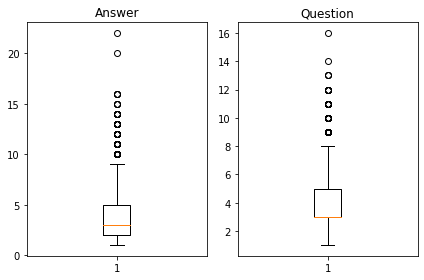

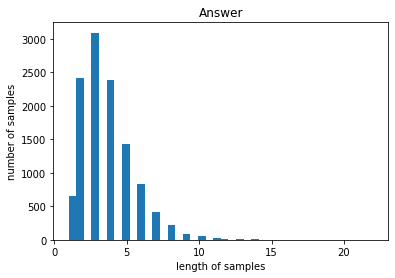

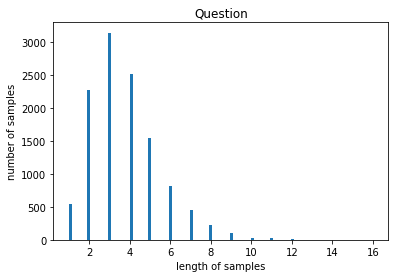

In [120]:
q_len = [len(s.split()) for s in data_temp['Q_tokenized']]
a_len = [len(s.split()) for s in data_temp['A_tokenized']]

print('질문의 최소 길이 : {}'.format(np.min(q_len)))
print('질문의 최대 길이 : {}'.format(np.max(q_len)))
print('질문의 평균 길이 : {}'.format(np.mean(q_len)))
print('답변의 최소 길이 : {}'.format(np.min(a_len)))
print('답변의 최대 길이 : {}'.format(np.max(a_len)))
print('답변의 평균 길이 : {}'.format(np.mean(a_len)))

plt.subplot(1,2,1)
plt.boxplot(a_len)
plt.title('Answer')
plt.subplot(1,2,2)
plt.boxplot(q_len)b
plt.title('Question')
plt.tight_layout()
plt.show()

plt.title('Answer')
plt.hist(a_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Question')
plt.hist(q_len, bins = 100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

질문의 최소 길이 : 0
질문의 최대 길이 : 22
질문의 평균 길이 : 5.107785971531469
답변의 최소 길이 : 0
답변의 최대 길이 : 29
답변의 평균 길이 : 5.44297719087635


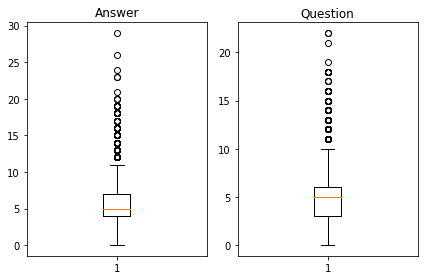

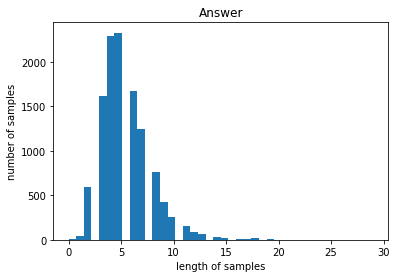

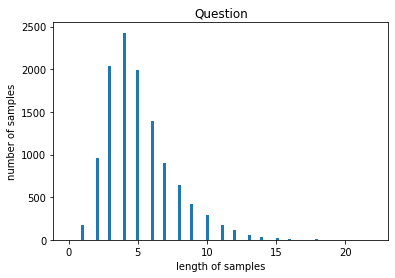

In [121]:
q_len = [len(s.split()) for s in data_temp['Q_final']]
a_len = [len(s.split()) for s in data_temp['A_final']]

print('질문의 최소 길이 : {}'.format(np.min(q_len)))
print('질문의 최대 길이 : {}'.format(np.max(q_len)))
print('질문의 평균 길이 : {}'.format(np.mean(q_len)))
print('답변의 최소 길이 : {}'.format(np.min(a_len)))
print('답변의 최대 길이 : {}'.format(np.max(a_len)))
print('답변의 평균 길이 : {}'.format(np.mean(a_len)))

plt.subplot(1,2,1)
plt.boxplot(a_len)
plt.title('Answer')
plt.subplot(1,2,2)
plt.boxplot(q_len)
plt.title('Question')
plt.tight_layout()
plt.show()

plt.title('Answer')
plt.hist(a_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Question')
plt.hist(q_len, bins = 100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [122]:
# 최소, 최대 사이에 있는 샘플을 골라 냅니다.
def bandpass_len(min_len, max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len) and (len(s.split()) >= min_len):
            cnt = cnt + 1
    print(f'전체 샘플 중 길이가 {min_len} 이상,{max_len} 이하인 샘플의 비율:{cnt / len(nested_list)}')

In [125]:
bandpass_len(3, 10, data_temp['A_final'])

전체 샘플 중 길이가 3 이상,10 이하인 샘플의 비율:0.9100497341793861


In [128]:
ans_min_len = 3
ans_max_len = 10

data_temp = data_temp[data_temp['A_final'].apply(lambda x: len(x.split()) <= ans_max_len \
            and len(x.split()) >= ans_min_len)]

질문의 최소 길이 : 1
질문의 최대 길이 : 16
질문의 평균 길이 : 3.762366908508433
답변의 최소 길이 : 1
답변의 최대 길이 : 10
답변의 평균 길이 : 3.6681428436822765


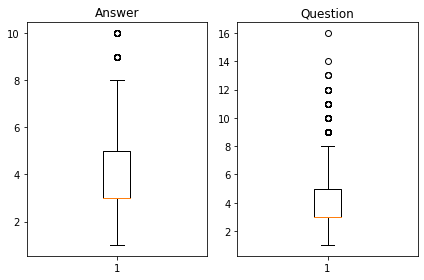

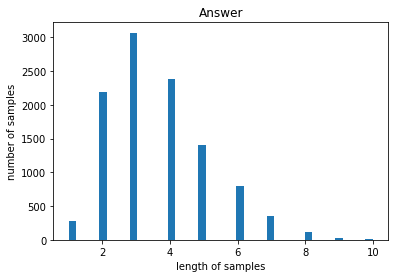

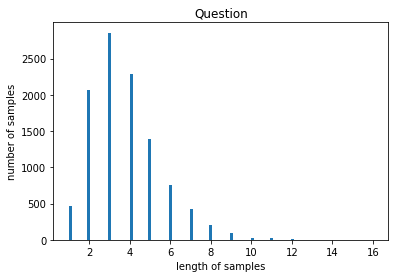

In [132]:
q_len = [len(s.split()) for s in data_temp['Q_tokenized']]
a_len = [len(s.split()) for s in data_temp['A_tokenized']]

print('질문의 최소 길이 : {}'.format(np.min(q_len)))
print('질문의 최대 길이 : {}'.format(np.max(q_len)))
print('질문의 평균 길이 : {}'.format(np.mean(q_len)))
print('답변의 최소 길이 : {}'.format(np.min(a_len)))
print('답변의 최대 길이 : {}'.format(np.max(a_len)))
print('답변의 평균 길이 : {}'.format(np.mean(a_len)))

plt.subplot(1,2,1)
plt.boxplot(a_len)
plt.title('Answer')
plt.subplot(1,2,2)
plt.boxplot(q_len)
plt.title('Question')
plt.tight_layout()
plt.show()

plt.title('Answer')
plt.hist(a_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Question')
plt.hist(q_len, bins = 100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

질문의 최소 길이 : 1
질문의 최대 길이 : 22
질문의 평균 길이 : 5.123527748987091
답변의 최소 길이 : 3
답변의 최대 길이 : 10
답변의 평균 길이 : 5.3670969565627065


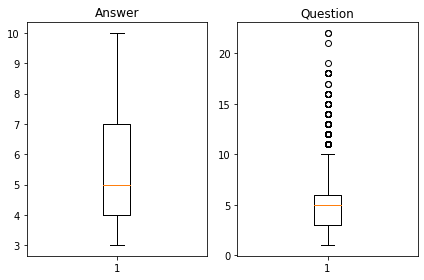

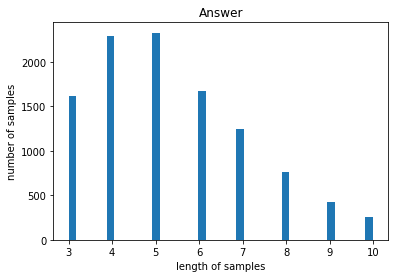

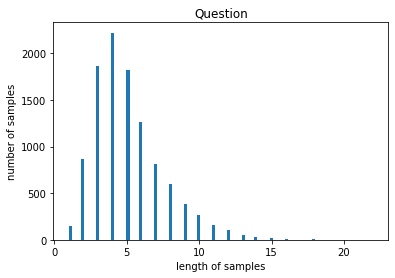

In [130]:
q_len = [len(s.split()) for s in data_temp['Q_final']]
a_len = [len(s.split()) for s in data_temp['A_final']]

print('질문의 최소 길이 : {}'.format(np.min(q_len)))
print('질문의 최대 길이 : {}'.format(np.max(q_len)))
print('질문의 평균 길이 : {}'.format(np.mean(q_len)))
print('답변의 최소 길이 : {}'.format(np.min(a_len)))
print('답변의 최대 길이 : {}'.format(np.max(a_len)))
print('답변의 평균 길이 : {}'.format(np.mean(a_len)))

plt.subplot(1,2,1)
plt.boxplot(a_len)
plt.title('Answer')
plt.subplot(1,2,2)
plt.boxplot(q_len)
plt.title('Question')
plt.tight_layout()
plt.show()

plt.title('Answer')
plt.hist(a_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Question')
plt.hist(q_len, bins = 100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

형태소 분리한 Q가 3 이상인 sample만 사용하겠습니다.

In [133]:
bandpass_len(3, 999, data_temp['Q_final'])

전체 샘플 중 길이가 3 이상,999 이하인 샘플의 비율:0.9053048148497126


In [134]:
ques_min_len = 3

data_temp = data_temp[data_temp['Q_final'].apply(lambda x: len(x.split()) >= ques_min_len)]

In [135]:
data_temp

,Q,A,label,Q_tokenized,A_tokenized,Q_final,A_final
0,12시 땡!,하루가 또 가네요.,0,시 땡 !,하루가 또 가네요,시 땡 !,하루 또 네요
1,1지망 학교 떨어졌어,위로해 드립니다.,0,지망 학교 떨어졌어,위로해 드립니다,지망 학교 떨어졌,위로 해 드립니다
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0,박일 놀러가고 싶다,여행은 언제나 좋죠,박일 놀 러 싶 다,여행 언제나 좋 죠
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0,박일 정도 놀러가고 싶다,여행은 언제나 좋죠,박일 정도 놀 러 싶 다,여행 언제나 좋 죠
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0,카드 안돼,다시 새로 사는 게 마음 편해요,카드 안 돼,다시 새로 사 마음 편해요
...,...,...,...,...,...,...,...
11814,회사에서 어떤 사람이랑 자꾸 눈 마추쳐.,눈 마주치는 게 우연인지 잘 살펴 보세요.,2,회사에서 어떤 사람이랑 자꾸 눈 마추쳐,눈 마주치는 게 우연인지 잘 살펴 보세요,회사 에서 어떤 사람 이랑 자꾸 눈 마추 쳐,눈 마주치 우연 인지 잘 살펴 보 세요
11817,후회 없이 사랑하고 싶어,진심으로 다가가 보세요.,2,후회 없이 사랑하고 싶어,진심으로 다가가 보세요,후회 없이 사랑 싶,진심 다가가 보 세요
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2,훔쳐보는 것도 눈치 보임,티가 나니까 눈치가 보이는 거죠 !,훔쳐 보 것 눈치 보임,티 나 니까 눈치 보이 죠 !
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2,힘든 연애 좋은 연애라는게 무슨 차이일까 ?,잘 헤어질 수 있는 사이 여부인 거 같아요,힘든 연애 좋 연애 라는 무슨 차이 일까 ?,잘 헤어질 수 있 사이 여부 같 아요


질문의 최소 길이 : 1
질문의 최대 길이 : 16
질문의 평균 길이 : 3.9731473771856787
답변의 최소 길이 : 1
답변의 최대 길이 : 10
답변의 평균 길이 : 3.7006661115736885


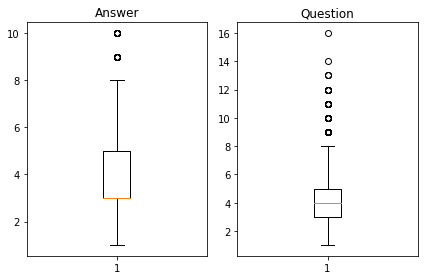

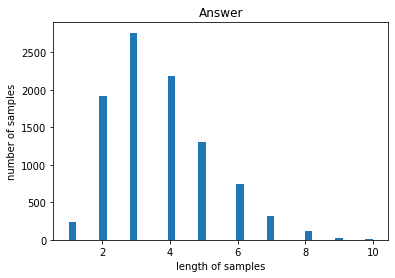

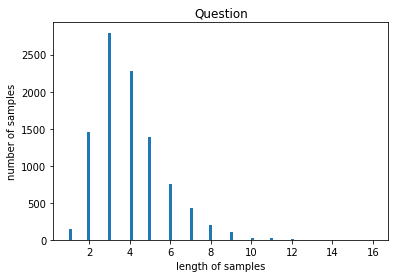

In [136]:
q_len = [len(s.split()) for s in data_temp['Q_tokenized']]
a_len = [len(s.split()) for s in data_temp['A_tokenized']]

print('질문의 최소 길이 : {}'.format(np.min(q_len)))
print('질문의 최대 길이 : {}'.format(np.max(q_len)))
print('질문의 평균 길이 : {}'.format(np.mean(q_len)))
print('답변의 최소 길이 : {}'.format(np.min(a_len)))
print('답변의 최대 길이 : {}'.format(np.max(a_len)))
print('답변의 평균 길이 : {}'.format(np.mean(a_len)))

plt.subplot(1,2,1)
plt.boxplot(a_len)
plt.title('Answer')
plt.subplot(1,2,2)
plt.boxplot(q_len)
plt.title('Question')
plt.tight_layout()
plt.show()

plt.title('Answer')
plt.hist(a_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Question')
plt.hist(q_len, bins = 100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

질문의 최소 길이 : 3
질문의 최대 길이 : 22
질문의 평균 길이 : 5.465133222314738
답변의 최소 길이 : 3
답변의 최대 길이 : 10
답변의 평균 길이 : 5.4200666111573685


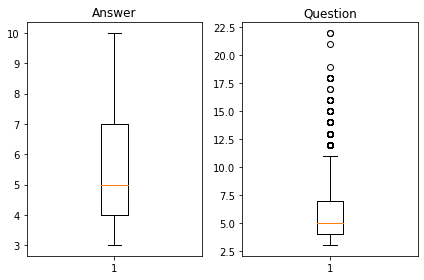

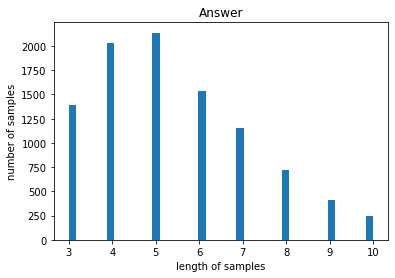

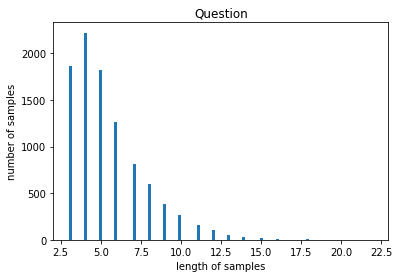

In [137]:
q_len = [len(s.split()) for s in data_temp['Q_final']]
a_len = [len(s.split()) for s in data_temp['A_final']]

print('질문의 최소 길이 : {}'.format(np.min(q_len)))
print('질문의 최대 길이 : {}'.format(np.max(q_len)))
print('질문의 평균 길이 : {}'.format(np.mean(q_len)))
print('답변의 최소 길이 : {}'.format(np.min(a_len)))
print('답변의 최대 길이 : {}'.format(np.max(a_len)))
print('답변의 평균 길이 : {}'.format(np.mean(a_len)))

plt.subplot(1,2,1)
plt.boxplot(a_len)
plt.title('Answer')
plt.subplot(1,2,2)
plt.boxplot(q_len)
plt.title('Question')
plt.tight_layout()
plt.show()

plt.title('Answer')
plt.hist(a_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Question')
plt.hist(q_len, bins = 100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [155]:
bandpass_len(3, 10, data_temp['A_final'])

전체 샘플 중 길이가 3 이상,10 이하인 샘플의 비율:1.0


In [158]:
bandpass_len(3, 10, data_temp['Q_final'])

전체 샘플 중 길이가 3 이상,10 이하인 샘플의 비율:0.9592006661115737


In [159]:
bandpass_len(1, 10, data_temp['Q_tokenized'])

전체 샘플 중 길이가 1 이상,10 이하인 샘플의 비율:0.9966694421315571


In [160]:
bandpass_len(1, 10, data_temp['A_tokenized'])

전체 샘플 중 길이가 1 이상,10 이하인 샘플의 비율:1.0


In [161]:
data_temp = data_temp[data_temp['Q_final'].apply(lambda x: len(x.split()) <= 10)]
data_temp = data_temp[data_temp['Q_tokenized'].apply(lambda x: len(x.split()) <= 10)]

In [162]:
bandpass_len(3, 10, data_temp['A_final'])

전체 샘플 중 길이가 3 이상,10 이하인 샘플의 비율:1.0


In [163]:
bandpass_len(3, 10, data_temp['Q_final'])

전체 샘플 중 길이가 3 이상,10 이하인 샘플의 비율:1.0


In [164]:
bandpass_len(1, 10, data_temp['Q_tokenized'])

전체 샘플 중 길이가 1 이상,10 이하인 샘플의 비율:1.0


In [165]:
bandpass_len(1, 10, data_temp['A_tokenized'])

전체 샘플 중 길이가 1 이상,10 이하인 샘플의 비율:1.0


In [213]:
data_temp.isna().sum(axis=0)


Q              0
A              0
label          0
Q_tokenized    0
A_tokenized    0
Q_final        0
A_final        0
dtype: int64

# Embedding
정수 인코딩과 embedding을 합니다. 만약 형태소 분리 전과 후를 같은 사전으로 인코딩한다면 '나 오늘 먹 걸었어' 와 같은 문장이 생성될 수 있습니다. 따라서. 두 개의 사전을 만든 뒤 한 쪽의 뒤에 이어 붙이겠습니다.

In [166]:
import tensorflow_datasets as tfds
tokenizer2 = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_temp['Q_tokenized'] + data_temp['A_tokenized'], target_vocab_size=6000)

In [208]:
tokenizer3 = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_temp['Q_final'] + data_temp['A_final'], target_vocab_size=8000)

In [202]:
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer2.encode(data_temp['Q_tokenized'][21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer2.encode(data_temp['A_tokenized'][21])))

정수 인코딩 후의 21번째 질문 샘플: [5590, 665, 2650, 4931]
정수 인코딩 후의 21번째 답변 샘플: [5365, 3430, 4, 12, 2068, 957]


In [203]:
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer2.encode(data_temp['Q_final'][21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer2.encode(data_temp['A_final'][21])))

정수 인코딩 후의 21번째 질문 샘플: [5590, 5631, 665, 2650, 4931]
정수 인코딩 후의 21번째 답변 샘플: [5365, 1224, 12, 2068, 5631, 957]


In [204]:
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer3.encode(data_temp['Q_tokenized'][21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer3.encode(data_temp['A_tokenized'][21])))

정수 인코딩 후의 21번째 질문 샘플: [12037, 11979, 11931, 12039, 11941, 11967, 253, 701, 7889]
정수 인코딩 후의 21번째 답변 샘플: [1157, 10224, 12039, 11954, 11947, 12038, 11941, 11951, 11835, 43, 12039, 11963, 11939, 12039, 11952, 11992, 347]


In [205]:
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer3.encode(data_temp['Q_final'][21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(np.array(tokenizer3.encode(data_temp['A_final'][21]))))

정수 인코딩 후의 21번째 질문 샘플: [1766, 253, 701, 7889]
정수 인코딩 후의 21번째 답변 샘플: [1157   93   43 1104  347]


In [195]:
list(np.array(tokenizer3.encode(data_temp['A_final'][21]))+6) +[4]

[874, 109, 44, 1459, 491, 4]

In [207]:
tokenizer2.vocab_size

5855

In [206]:
tokenizer3.vocab_size

12059

In [369]:
MAX_LENGTH = 22
START_TOKEN, END_TOKEN = [tokenizer2.vocab_size + tokenizer3.vocab_size], [tokenizer2.vocab_size + tokenizer3.vocab_size + 1]

In [256]:
def tokenize_and_filter1(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰을 추가
        sentence1 = START_TOKEN + tokenizer2.encode(sentence1)
        sentence2 = START_TOKEN + tokenizer2.encode(sentence2)

    # 최대 길이 11 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 최대 길이 11으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='pre')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [257]:
def tokenize_and_filter2(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = list(np.array(tokenizer3.encode(sentence1)) + tokenizer2.vocab_size) + END_TOKEN
        sentence2 = list(np.array(tokenizer3.encode(sentence2)) + tokenizer2.vocab_size) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='pre')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [258]:
questions1, answers1 = tokenize_and_filter1(data_temp['Q_tokenized'], data_temp['A_tokenized'])
print('단어장의 크기 :',(tokenizer2.vocab_size))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions1)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers1)))

단어장의 크기 : 5855
필터링 후의 질문 샘플 개수: 9216
필터링 후의 답변 샘플 개수: 9216


In [259]:
questions2, answers2 = tokenize_and_filter2(data_temp['Q_final'], data_temp['A_final'])
print('단어장의 크기 :',(tokenizer3.vocab_size))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions2)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers2)))

단어장의 크기 : 6783
필터링 후의 질문 샘플 개수: 9216
필터링 후의 답변 샘플 개수: 9216


In [309]:
VOCAB_SIZE = tokenizer2.vocab_size + tokenizer3.vocab_size + 2

In [260]:
questions1[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0, 12638,  1548,
        5834,  5748,  5760,    40], dtype=int32)

In [261]:
questions2[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
        5980, 11594,  5926, 12639], dtype=int32)

In [262]:
answers1[0]

array([12638,  4514,    72,  2000,    13,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0], dtype=int32)

In [263]:
answers2[0]

array([ 6087,  5960,  5869, 12639,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0], dtype=int32)

In [270]:
questions = np.hstack([questions1, questions2])
answers = np.hstack([answers1, answers2])

In [272]:
questions[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0, 12638,  1548,
        5834,  5748,  5760,    40,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,  5980, 11594,  5926, 12639],
      dtype=int32)

In [271]:
answers[0]

array([12638,  4514,    72,  2000,    13,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,  6087,  5960,  5869, 12639,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

# Implement Modified Transformer
maxlen=44, 초반 길이 22는 전처리된 QnA, 후반 길이 22는 형태소분리된 QnA로 입력이 주어질 때의 Transformer를 구현합니다.

In [732]:
# 포지셔널 인코딩 레이어1 - 36부터 시작합니다.
class PositionalEncodingMod(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncodingMod, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2) + 49) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용 (22까지)
        sines = tf.math.sin(angle_rads[:22, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용 (22까지)
        cosines1 = tf.math.cos(angle_rads[:22, 1::2])
        
        # 배열의 짝수 인덱스에는 cosine 함수 적용(24부터)
        cosines2 = tf.math.cos(angle_rads[22:, 0::2])
        # 배열의 홀수 인덱스에는 -sine 함수 적용
        neg_sines = -tf.math.sin(angle_rads[22:, 1::2])
        
        
        # sin과 cosine이 교차되도록 재배열
        
        pos_encoding1 = tf.stack([sines, cosines1], axis=0)
        pos_encoding2 = tf.stack([cosines2, neg_sines], axis=0)
        pos_encoding = tf.concat([pos_encoding1, pos_encoding2], 1)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

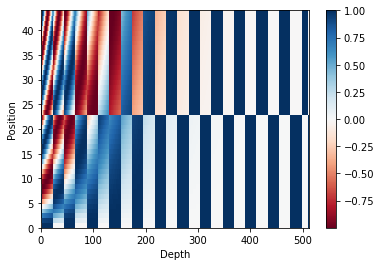

In [733]:
sample_pos_encoding = PositionalEncodingMod(44, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

4등분해서 가리는 삼각형 역시 4개가 됩니다.

In [734]:
@tf.function
def create_look_ahead_mask_mod(x):
    seq_len = tf.shape(x)[1]
    if seq_len% 2==1:
        look_ahead_mask_unit_top_left = 1 - tf.linalg.band_part(tf.ones((seq_len//2 + 1 , seq_len//2 + 1)), -1, 0)
        look_ahead_mask_unit_top_right = 1 - tf.linalg.band_part(tf.ones((seq_len//2 + 1 , seq_len//2)), -1, 0)
        look_ahead_mask_unit_bot_left = 1 - tf.linalg.band_part(tf.ones((seq_len//2 , seq_len//2 + 1)), -1, 0)
        look_ahead_mask_unit_bot_right = 1 - tf.linalg.band_part(tf.ones((seq_len//2 , seq_len//2)), -1, 0)


        look_ahead_mask_row1 = tf.concat([look_ahead_mask_unit_top_left,look_ahead_mask_unit_top_right],1)
        look_ahead_mask_row2 = tf.concat([look_ahead_mask_unit_bot_left,look_ahead_mask_unit_bot_right],1)

        look_ahead_mask = tf.concat([look_ahead_mask_row1,look_ahead_mask_row2],0)
    
    else:
        look_ahead_mask_unit = 1 - tf.linalg.band_part(tf.ones((seq_len//2 , seq_len//2 )), -1, 0)
        look_ahead_mask_row = tf.concat([look_ahead_mask_unit,look_ahead_mask_unit],1)
        look_ahead_mask = tf.concat([look_ahead_mask_row,look_ahead_mask_row],0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [735]:
look_ahead_mask1 = 1 - tf.linalg.band_part(tf.ones((12//2, 12//2)), -1, 0)
look_ahead_mask2 = tf.concat([look_ahead_mask1,look_ahead_mask1],1)
look_ahead_mask3 = tf.concat([look_ahead_mask2,look_ahead_mask2],0)
look_ahead_mask3

<tf.Tensor: shape=(12, 12), dtype=float32, numpy=
array([[0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [736]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [737]:
def encoder_mod(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncodingMod(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [738]:
def decoder_mod(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask_mod = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask_mod')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncodingMod(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask_mod, padding_mask])

    return tf.keras.Model(
    inputs=[inputs, enc_outputs, look_ahead_mask_mod, padding_mask],
    outputs=outputs,
    name=name)

In [739]:
def transformer_mod(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask_mod = tf.keras.layers.Lambda(
      create_look_ahead_mask_mod,
      output_shape=(1, None, None),
      name='look_ahead_mask_mod')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder_mod(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder_mod(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask_mod, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [740]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer_mod(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    4290048     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [741]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [742]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

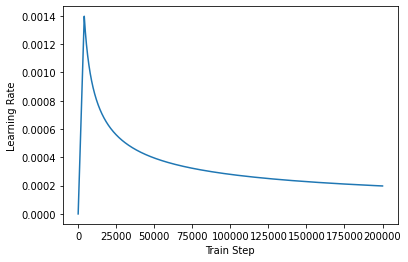

In [743]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [746]:
MAX_LENGTH = 46

In [747]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [748]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
144/144 [==============================] - 31s 162ms/step - loss: 2.8303 - accuracy: 0.0207
Epoch 2/20
144/144 [==============================] - 24s 164ms/step - loss: 2.4658 - accuracy: 0.0602
Epoch 3/20
144/144 [==============================] - 23s 160ms/step - loss: 2.0424 - accuracy: 0.0672
Epoch 4/20
144/144 [==============================] - 22s 155ms/step - loss: 1.7459 - accuracy: 0.0728
Epoch 5/20
144/144 [==============================] - 23s 156ms/step - loss: 1.6013 - accuracy: 0.0843
Epoch 6/20
144/144 [==============================] - 23s 158ms/step - loss: 1.5044 - accuracy: 0.0915
Epoch 7/20
144/144 [==============================] - 22s 154ms/step - loss: 1.4153 - accuracy: 0.0991
Epoch 8/20
144/144 [==============================] - 23s 156ms/step - loss: 1.3292 - accuracy: 0.1062
Epoch 9/20
144/144 [==============================] - 23s 157ms/step - loss: 1.2358 - accuracy: 0.1153
Epoch 10/20
114/144 [======================>.......] - ETA: 4s - loss: 1.

KeyboardInterrupt: 

In [529]:
def decoder_inference(sentence):
    sentence = preprocess_qna(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer2.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [530]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer2.decode(
      [i for i in prediction if i < tokenizer2.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [536]:
sentence_generation('나는 사실 기분이 너무 좋아')

입력 : 나는 사실 기분이 너무 좋아
출력 : 달도움을 청해보세요겠네요해요네요해요 겠네요해요


'달도움을 청해보세요겠네요해요네요해요 겠네요해요'

학습을 더 시켜봅니다.

In [713]:
def decoder_inference_mod(sentence):
    sentence = preprocess_qna(sentence)
    morph_sentence = tokenize_qna(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
      [0]*(22-len(tokenizer2.encode(sentence)))+START_TOKEN + tokenizer2.encode(sentence) +[0]*(22-len(tokenizer3.encode(morph_sentence))) + tokenizer3.encode(morph_sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. 
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(22):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]
        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        pid = predicted_id.numpy()
        pid = pid[0][0]
        
        while pid >= tokenizer2.vocab_size and pid !=END_TOKEN[0]:
            pred = predictions.numpy()
            pred[0][0][pid] *= 0.001
            predictions = tf.convert_to_tensor(pred, dtype=tf.float32)
            predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
            pid = predicted_id.numpy()
            pid = pid[0][0]

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [714]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference_mod(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer2.decode(
      [i for i in prediction if i < tokenizer2.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [715]:
sentence_generation('그게 무슨 말인지 잘 모르겠어 이제 그만할까?')

입력 : 그게 무슨 말인지 잘 모르겠어 이제 그만할까?
출력 : 기다리기만 하다가 놓치건 없어요 그분의 사람들이 없어요 좋아할 수도 있어요이면 오히려 더 좋아할 거예요�


'기다리기만 하다가 놓치건 없어요 그분의 사람들이 없어요 좋아할 수도 있어요이면 오히려 더 좋아할 거예요�'

In [716]:
sentence_generation('무슨 의미일까 너의 말은')

입력 : 무슨 의미일까 너의 말은
출력 : 역할을 좋아하나 자신 스스로에게 의지해역할을 거예요다 경험일 수도 있어요였역할사랑했나봐요역


'역할을 좋아하나 자신 스스로에게 의지해역할을 거예요다 경험일 수도 있어요였역할사랑했나봐요역'

In [717]:
sentence_generation('내가 뭘 하면 좋을지 알려줄 사람이 있을까?')

입력 : 내가 뭘 하면 좋을지 알려줄 사람이 있을까?
출력 : 기다리세요 공부는 끝이 있으니까요요청해보세요로 가요 ? 북은 문제니까요니까요거나 예요하늘 아쉬운 일이 


'기다리세요 공부는 끝이 있으니까요요청해보세요로 가요 ? 북은 문제니까요니까요거나 예요하늘 아쉬운 일이 '

In [718]:
sentence_generation('출근길 너무 힘들어')

입력 : 출근길 너무 힘들어
출력 : 좋은 생각이에요 혼자가 않아도 돼요가해요거예요 ! 나을 수도 있어요이면 마세요 걱정되겠어요,내 좋을거


'좋은 생각이에요 혼자가 않아도 돼요가해요거예요 ! 나을 수도 있어요이면 마세요 걱정되겠어요,내 좋을거'

훈련의 구조를 START_TOKEN + 전처리 문장 + 형태소 분리 문장 + END_TOKEN으로 넣어서 문장의 끝을 모르는 일이 발생했습니다. END_TOKEN을 양쪽에 넣어줍니다.

In [749]:
MAX_LENGTH = 23
VOCAB_SIZE = tokenizer2.vocab_size + tokenizer3.vocab_size
START_TOKEN, END_TOKEN, START_TOKEN2, END_TOKEN2 = [VOCAB_SIZE], [VOCAB_SIZE + 1], [VOCAB_SIZE + 2], [VOCAB_SIZE + 3]
VOCAB_SIZE +=4

In [750]:
def tokenize_and_filter1(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰, 끝 토큰을 추가
        sentence1 = START_TOKEN + tokenizer2.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer2.encode(sentence2) + END_TOKEN

    # 최대 길이 11 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 최대 길이 11으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='pre')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [751]:
def tokenize_and_filter2(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN2 + list(np.array(tokenizer3.encode(sentence1)) + tokenizer2.vocab_size) + END_TOKEN2
        sentence2 = START_TOKEN2 + list(np.array(tokenizer3.encode(sentence2)) + tokenizer2.vocab_size) + END_TOKEN2

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='pre')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [752]:
questions1, answers1 = tokenize_and_filter1(data_temp['Q_tokenized'], data_temp['A_tokenized'])
print('단어장의 크기 :',(tokenizer2.vocab_size))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions1)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers1)))

단어장의 크기 : 5855
필터링 후의 질문 샘플 개수: 9216
필터링 후의 답변 샘플 개수: 9216


In [753]:
questions2, answers2 = tokenize_and_filter2(data_temp['Q_final'], data_temp['A_final'])
print('단어장의 크기 :',(tokenizer3.vocab_size))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions2)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers2)))

단어장의 크기 : 6783
필터링 후의 질문 샘플 개수: 9216
필터링 후의 답변 샘플 개수: 9216


In [754]:
VOCAB_SIZE = tokenizer2.vocab_size + tokenizer3.vocab_size + 2

In [755]:
questions1[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0, 12638,  1548,
        5834,  5748,  5760,    40, 12639], dtype=int32)

In [756]:
questions2[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
       12640,  5980, 11594,  5926, 12641], dtype=int32)

In [757]:
answers1[0]

array([12638,  4514,    72,  2000,    13, 12639,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [758]:
answers2[0]

array([12640,  6087,  5960,  5869, 12641,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [759]:
questions = np.hstack([questions1, questions2])
answers = np.hstack([answers1, answers2])

In [760]:
questions[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0, 12638,  1548,
        5834,  5748,  5760,    40, 12639,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0, 12640,  5980, 11594,  5926,
       12641], dtype=int32)

In [761]:
answers[0]

array([12638,  4514,    72,  2000,    13, 12639,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0, 12640,  6087,  5960,  5869,
       12641,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

# Implement Modified Transformer
maxlen=46, 초반 길이 23는 전처리된 QnA, 후반 길이 23는 형태소분리된 QnA로 입력이 주어질 때의 Transformer를 구현합니다.

In [762]:
# 포지셔널 인코딩 레이어1 - 36부터 시작합니다.
class PositionalEncodingMod(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncodingMod, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2) + 49) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용 (23까지)
        sines = tf.math.sin(angle_rads[:23, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용 (23까지)
        cosines1 = tf.math.cos(angle_rads[:23, 1::2])
        
        # 배열의 짝수 인덱스에는 cosine 함수 적용(24부터)
        cosines2 = tf.math.cos(angle_rads[23:, 0::2])
        # 배열의 홀수 인덱스에는 -sine 함수 적용
        neg_sines = -tf.math.sin(angle_rads[23:, 1::2])
        
        
        # sin과 cosine이 교차되도록 재배열
        
        pos_encoding1 = tf.stack([sines, cosines1], axis=0)
        pos_encoding2 = tf.stack([cosines2, neg_sines], axis=0)
        pos_encoding = tf.concat([pos_encoding1, pos_encoding2], 1)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

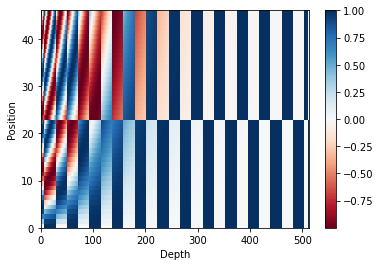

In [764]:
sample_pos_encoding = PositionalEncodingMod(46, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

4등분해서 가리는 삼각형 역시 4개가 됩니다.

In [765]:
@tf.function
def create_look_ahead_mask_mod(x):
    seq_len = tf.shape(x)[1]
    if seq_len% 2==1:
        look_ahead_mask_unit_top_left = 1 - tf.linalg.band_part(tf.ones((seq_len//2 + 1 , seq_len//2 + 1)), -1, 0)
        look_ahead_mask_unit_top_right = 1 - tf.linalg.band_part(tf.ones((seq_len//2 + 1 , seq_len//2)), -1, 0)
        look_ahead_mask_unit_bot_left = 1 - tf.linalg.band_part(tf.ones((seq_len//2 , seq_len//2 + 1)), -1, 0)
        look_ahead_mask_unit_bot_right = 1 - tf.linalg.band_part(tf.ones((seq_len//2 , seq_len//2)), -1, 0)


        look_ahead_mask_row1 = tf.concat([look_ahead_mask_unit_top_left,look_ahead_mask_unit_top_right],1)
        look_ahead_mask_row2 = tf.concat([look_ahead_mask_unit_bot_left,look_ahead_mask_unit_bot_right],1)

        look_ahead_mask = tf.concat([look_ahead_mask_row1,look_ahead_mask_row2],0)
    
    else:
        look_ahead_mask_unit = 1 - tf.linalg.band_part(tf.ones((seq_len//2 , seq_len//2 )), -1, 0)
        look_ahead_mask_row = tf.concat([look_ahead_mask_unit,look_ahead_mask_unit],1)
        look_ahead_mask = tf.concat([look_ahead_mask_row,look_ahead_mask_row],0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [766]:
look_ahead_mask1 = 1 - tf.linalg.band_part(tf.ones((12//2, 12//2)), -1, 0)
look_ahead_mask2 = tf.concat([look_ahead_mask1,look_ahead_mask1],1)
look_ahead_mask3 = tf.concat([look_ahead_mask2,look_ahead_mask2],0)
look_ahead_mask3

<tf.Tensor: shape=(12, 12), dtype=float32, numpy=
array([[0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [767]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [768]:
def encoder_mod(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncodingMod(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [769]:
def decoder_mod(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask_mod = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask_mod')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncodingMod(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask_mod, padding_mask])

    return tf.keras.Model(
    inputs=[inputs, enc_outputs, look_ahead_mask_mod, padding_mask],
    outputs=outputs,
    name=name)

In [770]:
def transformer_mod(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask_mod = tf.keras.layers.Lambda(
      create_look_ahead_mask_mod,
      output_shape=(1, None, None),
      name='look_ahead_mask_mod')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder_mod(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder_mod(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask_mod, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [775]:
MAX_LENGTH = 46
VOCAB_SIZE = tokenizer2.vocab_size + tokenizer3.vocab_size
START_TOKEN, END_TOKEN, START_TOKEN2, END_TOKEN2 = [VOCAB_SIZE], [VOCAB_SIZE + 1], [VOCAB_SIZE + 2], [VOCAB_SIZE + 3]
VOCAB_SIZE +=4

In [776]:
VOCAB_SIZE

12642

In [777]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer_mod(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    4290560     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [778]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [779]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

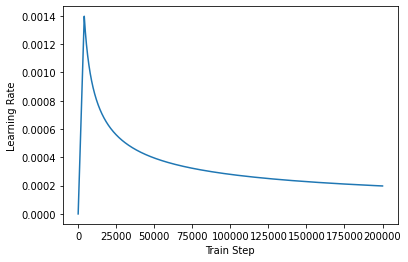

In [780]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [782]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [783]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
144/144 [==============================] - 31s 159ms/step - loss: 2.8470 - accuracy: 0.0140
Epoch 2/20
144/144 [==============================] - 23s 157ms/step - loss: 2.4802 - accuracy: 0.0667
Epoch 3/20
144/144 [==============================] - 23s 156ms/step - loss: 2.0307 - accuracy: 0.0670
Epoch 4/20
144/144 [==============================] - 23s 158ms/step - loss: 1.7252 - accuracy: 0.0729
Epoch 5/20
144/144 [==============================] - 23s 159ms/step - loss: 1.6015 - accuracy: 0.0854
Epoch 6/20
144/144 [==============================] - 23s 159ms/step - loss: 1.4991 - accuracy: 0.0924
Epoch 7/20
144/144 [==============================] - 23s 157ms/step - loss: 1.4141 - accuracy: 0.0987
Epoch 8/20
144/144 [==============================] - 22s 156ms/step - loss: 1.3313 - accuracy: 0.1065
Epoch 9/20
144/144 [==============================] - 23s 158ms/step - loss: 1.2464 - accuracy: 0.1170
Epoch 10/20
144/144 [==============================] - 23s 157ms/step - l

In [784]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
144/144 [==============================] - 23s 159ms/step - loss: 0.1081 - accuracy: 0.2827
Epoch 2/20
144/144 [==============================] - 23s 159ms/step - loss: 0.0858 - accuracy: 0.2868
Epoch 3/20
144/144 [==============================] - 23s 157ms/step - loss: 0.0713 - accuracy: 0.2891
Epoch 4/20
144/144 [==============================] - 23s 158ms/step - loss: 0.0607 - accuracy: 0.2912
Epoch 5/20
144/144 [==============================] - 23s 159ms/step - loss: 0.0560 - accuracy: 0.2919
Epoch 6/20
144/144 [==============================] - 23s 158ms/step - loss: 0.0533 - accuracy: 0.2922
Epoch 7/20
144/144 [==============================] - 23s 158ms/step - loss: 0.0492 - accuracy: 0.2931
Epoch 8/20
144/144 [==============================] - 23s 158ms/step - loss: 0.0473 - accuracy: 0.2933
Epoch 9/20
144/144 [==============================] - 23s 161ms/step - loss: 0.0439 - accuracy: 0.2943
Epoch 10/20
144/144 [==============================] - 23s 160ms/step - l

In [785]:
def decoder_inference_mod(sentence):
    sentence = preprocess_qna(sentence)
    morph_sentence = tokenize_qna(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
      [0]*(22-len(tokenizer2.encode(sentence)))+START_TOKEN + tokenizer2.encode(sentence) +[0]*(22-len(tokenizer3.encode(morph_sentence))) + tokenizer3.encode(morph_sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. 
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(22):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]
        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        pid = predicted_id.numpy()
        pid = pid[0][0]
        
        while pid >= tokenizer2.vocab_size and pid !=END_TOKEN[0]:
            pred = predictions.numpy()
            pred[0][0][pid] *= 0.001
            predictions = tf.convert_to_tensor(pred, dtype=tf.float32)
            predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
            pid = predicted_id.numpy()
            pid = pid[0][0]

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [786]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference_mod(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer2.decode(
      [i for i in prediction if i < tokenizer2.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [787]:
sentence_generation('그게 무슨 말인지 잘 모르겠어 이제 그만할까?')

입력 : 그게 무슨 말인지 잘 모르겠어 이제 그만할까?
출력 : 앞으로가 많이 하면 좋죠


'앞으로가 많이 하면 좋죠'

In [788]:
sentence_generation('무슨 의미일까 너의 말은')

입력 : 무슨 의미일까 너의 말은
출력 : 잘했어요 않았나봐요


'잘했어요 않았나봐요'

In [789]:
sentence_generation('내가 뭘 하면 좋을지 알려줄 사람이 있을까?')

입력 : 내가 뭘 하면 좋을지 알려줄 사람이 있을까?
출력 : 그러니 잘 위해 거처럼 잘 풀릴 거예요


'그러니 잘 위해 거처럼 잘 풀릴 거예요'

In [790]:
sentence_generation('출근길 너무 힘들어')

입력 : 출근길 너무 힘들어
출력 : 즐거운 시간 멈추축된 직장 스트레스가 심한가봐요


'즐거운 시간 멈추축된 직장 스트레스가 심한가봐요'

In [792]:
sentence_generation('내일 고백하려고 해 너무 떨려')

입력 : 내일 고백하려고 해 너무 떨려
출력 : 잘하고 싶은 마음을 정리하세요


'잘하고 싶은 마음을 정리하세요'

In [793]:
sentence_generation('요즘 왜 자꾸 우울할까?')

입력 : 요즘 왜 자꾸 우울할까?
출력 : 달콤한 차라도 한 잔 차라도 차로 바로 바로 바로 바로 풀어요


'달콤한 차라도 한 잔 차라도 차로 바로 바로 바로 바로 풀어요'

In [794]:
sentence_generation('오늘 왜 이렇게 금요일 같지?')

입력 : 오늘 왜 이렇게 금요일 같지?
출력 : 매력이라면 수없죠


'매력이라면 수없죠'

In [795]:
sentence_generation('날씨가 좋아?')

입력 : 날씨가 좋아?
출력 : 집밖에 나가면 어디든 좋아요


'집밖에 나가면 어디든 좋아요'

In [796]:
sentence_generation('날씨가 좋아!')

입력 : 날씨가 좋아!
출력 : 집밖에 나가면 어디든 


'집밖에 나가면 어디든 '

In [800]:
sentence_generation('요즘따라 슬픈 일이 자꾸 생각나')

입력 : 요즘따라 슬픈 일이 자꾸 생각나
출력 : 좀 먹어요


'좀 먹어요'

In [801]:
sentence_generation('너는 누구니?')

입력 : 너는 누구니?
출력 : 그래도 같이 이야기 해요


'그래도 같이 이야기 해요'

In [803]:
sentence_generation('내가 멋지게 사는 날이 올까?')

입력 : 내가 멋지게 사는 날이 올까?
출력 : 직접 물어보세요


'직접 물어보세요'

In [807]:
sentence_generation('잘 보이려면 어떻게 해야 할까?')

입력 : 잘 보이려면 어떻게 해야 할까?
출력 : 사는 선이야기가 자신이 없다면 조금씩 함께 만나는게 좋겠어요


'사는 선이야기가 자신이 없다면 조금씩 함께 만나는게 좋겠어요'

In [808]:
sentence_generation('선물을 무엇을 하는게 좋을까?')

입력 : 선물을 무엇을 하는게 좋을까?
출력 : 아직은 부담스럽지 않길 바랍니다


'아직은 부담스럽지 않길 바랍니다'

In [811]:
sentence_generation('고백을 먼저 하는게 좋을까?')

입력 : 고백을 먼저 하는게 좋을까?
출력 : 먼저 용기내서 먼저 해보세요


'먼저 용기내서 먼저 해보세요'

동어반복이 있습니다. 동어 반복을 해결하겠습니다.

In [825]:
def decoder_inference_mod(sentence):
    sentence = preprocess_qna(sentence)
    morph_sentence = tokenize_qna(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
      [0]*(22-len(tokenizer2.encode(sentence)))+START_TOKEN + tokenizer2.encode(sentence) +[0]*(22-len(tokenizer3.encode(morph_sentence))) + tokenizer3.encode(morph_sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. 
    output_sequence = tf.expand_dims(START_TOKEN, 0)
    
    ### 나온 단어 인덱스를 기록합니다
    token_bag = set()
    ###
    
    # 디코더의 인퍼런스 단계
    for i in range(22):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]
        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        pid = predicted_id.numpy()
        pid = pid[0][0]
        
        while pid >= tokenizer2.vocab_size and pid !=END_TOKEN[0]:
            pred = predictions.numpy()
            pred[0][0][pid] *= 0.001
            predictions = tf.convert_to_tensor(pred, dtype=tf.float32)
            predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
            pid = predicted_id.numpy()
            pid = pid[0][0]
            if pid in token_bag:
                pred = predictions.numpy()
                pred[0][0][pid] *= 0.05
                predictions = tf.convert_to_tensor(pred, dtype=tf.float32)
                predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
                pid = predicted_id.numpy()
                pid = pid[0][0]
                
        token_bag.add(pid)  # 추가합니다(동어반복 방지)
            

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [826]:
sentence_generation('출근길 너무 힘들어')

입력 : 출근길 너무 힘들어
출력 : 즐거운 시간 멈추축된 직장 스트레스가 심한가봐요


'즐거운 시간 멈추축된 직장 스트레스가 심한가봐요'

In [827]:
sentence_generation('내일 고백하려고 해 너무 떨려')

입력 : 내일 고백하려고 해 너무 떨려
출력 : 잘하고 싶은 마음을 정리하세요


'잘하고 싶은 마음을 정리하세요'

In [828]:
sentence_generation('요즘 왜 자꾸 우울할까?')

입력 : 요즘 왜 자꾸 우울할까?
출력 : 달콤한 차라도 한 잔 차라도 차로 바로 바로 풀어요


'달콤한 차라도 한 잔 차라도 차로 바로 바로 풀어요'

In [829]:
sentence_generation('오늘 왜 이렇게 금요일 같지?')

입력 : 오늘 왜 이렇게 금요일 같지?
출력 : 매력이라면 수없죠


'매력이라면 수없죠'

In [830]:
sentence_generation('날씨가 좋아?')

입력 : 날씨가 좋아?
출력 : 집밖에 나가면 어디든 좋아요


'집밖에 나가면 어디든 좋아요'

In [831]:
sentence_generation('날씨가 좋아!')

입력 : 날씨가 좋아!
출력 : 집밖에 나가면 어디든 


'집밖에 나가면 어디든 '

In [832]:
sentence_generation('요즘따라 슬픈 일이 자꾸 생각나')

입력 : 요즘따라 슬픈 일이 자꾸 생각나
출력 : 좀 먹어요


'좀 먹어요'

In [833]:
sentence_generation('너는 누구니?')

입력 : 너는 누구니?
출력 : 그래도 같이 이야기 해요


'그래도 같이 이야기 해요'

In [834]:
sentence_generation('내가 멋지게 사는 날이 올까?')

입력 : 내가 멋지게 사는 날이 올까?
출력 : 직접 물어보세요


'직접 물어보세요'

In [835]:
sentence_generation('잘 보이려면 어떻게 해야 할까?')

입력 : 잘 보이려면 어떻게 해야 할까?
출력 : 사는 선이야기가 자신이 없다면 조금씩 함께 만나는게 좋겠어요


'사는 선이야기가 자신이 없다면 조금씩 함께 만나는게 좋겠어요'

In [836]:
sentence_generation('선물을 무엇을 하는게 좋을까?')

입력 : 선물을 무엇을 하는게 좋을까?
출력 : 아직은 부담스럽지 않길 바랍니다


'아직은 부담스럽지 않길 바랍니다'

In [837]:
sentence_generation('고백을 먼저 하는게 좋을까?')

입력 : 고백을 먼저 하는게 좋을까?
출력 : 먼저 용기내서 먼저 해보세요


'먼저 용기내서 먼저 해보세요'

In [849]:
sentence_generation('나 요즘 즐겁지 않아')

입력 : 나 요즘 즐겁지 않아
출력 : 자신이 편하고 있지 않았나봐요


'자신이 편하고 있지 않았나봐요'

In [853]:
sentence_generation('이제 결혼하고 싶어')

입력 : 이제 결혼하고 싶어
출력 : 좋은 사람이랑 결혼할 때가 결혼적령기예요


'좋은 사람이랑 결혼할 때가 결혼적령기예요'

바로바로바로바로에서 바로바로로 바뀐 것을 확인했습니다.

# 회고
1️⃣ 잘한 점:

원하는 구조의 트랜스포머를 구현하고, inference에서 동어 반복과 END_TOKEN을 찾지 못하는 현상을 수정해 제대로 된 문장을 만들었습니다.

2️⃣ 어려웠던 점:

Positional Encoding을 변형한 것

Look-ahead Masking을 변형한 것

encoder, decoder를 변형한 것

inference에서 tensor와 np.array의 차이 때문에 원하는 연산을 하는데 복잡하게 돌아간 것


3️⃣ 느낀 점:

새로운 구조를 생각대로 만들어 내려니 시간이 매우 많이 들었고, 과연 이게 될까 하는 생각이 많이 들었습니다